<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_09_Data_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Feature Augmentation

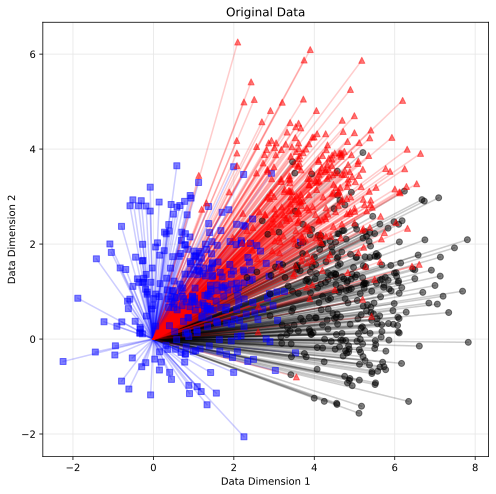

In [2]:
# Create the Qwerties Dataset

# Number of data points
nPerClust = 300
# define SDV
blur = 1

A = [1,1]
B = [5,1]
C = [4,3]

# Generate the data around these points
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]

data_np = np.hstack((a,b,c)).T

# Define the true labels
labels_np = np.hstack((np.zeros((nPerClust)),
                       np.ones((nPerClust)),
                       np.ones((nPerClust)) +1))

# Convert them into tensors
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

# PLot the whole thing
fig = plt.figure(figsize=(8,8))

# Draw the distances of every point to the origin
color = "bkr"
for i in range(len(data)):
    plt.plot([0,data[i,0]], [0,data[i,1]], color = color[labels[i]], alpha=0.2)

plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1],"bs", alpha=0.5)
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1],"ko", alpha=0.5)
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1],"r^", alpha=0.5)

plt.grid(color=[0.9,0.9,0.9])
plt.title("Original Data")
plt.xlabel("Data Dimension 1")
plt.ylabel("Data Dimension 2")
plt.show()

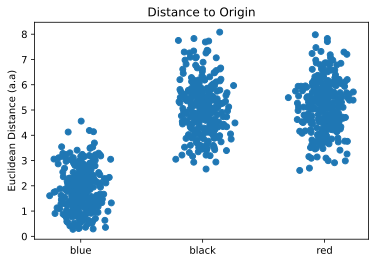

In [3]:
# Compute the euclidean distance to the origin for each data point
dist2origin = torch.sqrt(data[:,0]**2 + data[:,1]**2)

plt.plot(labels+torch.randn(900)/10, dist2origin, "o")
plt.xticks([0,1,2], labels=["blue", "black", "red"])
plt.ylabel("Euclidean Distance (a.a)")
plt.title("Distance to Origin")
plt.show()
# Blue data closer to the origin as compared to black and red

In [4]:
# Add the euclidean distance data to the data matrix as a third dimension
# reshape the distance vector into a column vector to concatenate to the original data
dataAug = torch.cat((data, dist2origin.view(len(data),1)),axis=1)

# CHeck data sizes
print(data.shape)
print()
print(dataAug.shape)

torch.Size([900, 2])

torch.Size([900, 3])


In [5]:
# Take a look at the data created
dataAug

tensor([[ 0.7951,  2.2189,  2.3571],
        [ 2.1137,  1.0759,  2.3718],
        [ 1.5654, -1.1390,  1.9359],
        ...,
        [ 5.8842,  3.5319,  6.8628],
        [ 3.6638,  3.0453,  4.7642],
        [ 3.4173,  3.8474,  5.1459]])

In [6]:
# Use sikitlearn to split the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(dataAug, labels, test_size=0.1)

# Convert them to PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle = True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [7]:
# Create the Model
def createTheQwertyNet(useExtraFeature=False):

    class QwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Define the input layer
            if useExtraFeature:
                self.input = nn.Linear(3,8)
            else:
                self.input = nn.Linear(2,8)
            
            # Hidden Layer
            self.fc1 = nn.Linear(8,8)

            # Output Layer
            self.output = nn.Linear(8,3)

        # Forward Pass
        def forward(self,x):
            # Add another condition here
            #print(x.shape) # Comment out during training
            if not useExtraFeature:
                x = x[:,:2]
            #print(x.shape) # Again comment out during training

            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return F.relu(self.output(x))
    
    # Create the model instance
    net = QwertyNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimization function
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

    return net, lossfun, optimizer

In [8]:
# Check to make sure the model is working fine
print("Using Augmented Feature:")
net = createTheQwertyNet(True)[0]
net(next(iter(train_loader))[0]);

print("\nNot using Augmented Feature:")
net = createTheQwertyNet(False)[0]
net(next(iter(train_loader))[0]);

Using Augmented Feature:

Not using Augmented Feature:


In [9]:
# Define a function to train the model
def function2trainTheModel(useExtraFeature=False):

    # Define the number of epochs
    numepochs = 200

    # Create a new model
    net, lossfun, optimizer = createTheQwertyNet(useExtraFeature)

    # INitialize the losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Initialize the batches information
        batchAcc = []
        batchLoss = []

        # Loop over the batches
        for X,y in train_loader:

            # Forward Pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackPropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Store the losses for this particular batch
            batchLoss.append(loss.item())

            # Store batch Accuracy
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
        # End of batch
        # Save the mean accuracy and loss for the batches in one epoch
        trainAcc.append(np.mean(batchAcc))
        losses[epochi,0] = np.mean(batchLoss)

        # Test the Accuracy for each epoch
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        # Test Losses per epoch
        losses[epochi,1] = lossfun(yHat,y).item()

        # Test Accuracy per epich
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    # End of all epochs
    # Return the calculations
    return trainAcc, testAcc, losses, net

In [10]:
# Define a function to plot the results
def plotTheResults():

    # COmpute the accuracy over the entire dataset (train+test)
    yHat = net(dataAug)
    predictions = torch.argmax(yHat,axis=1)
    accuracy = (predictions == labels).float()

    # Accuracy by group
    accuracyByGroup = np.zeros(3)
    for i in range(3):
        accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])
    
    # Create the figure
    fig,ax = plt.subplots(2,2, figsize=(10,6))

    # PLot loss function
    ax[0,0].plot(losses)
    ax[0,0].set_ylabel("Losses")
    ax[0,0].set_xlabel("Training Epoch")
    ax[0,0].set_title("Losses")
    ax[0,0].legend()


    # PLot Accuracy
    ax[0,1].plot(trainAcc, label="Train")
    ax[0,1].plot(testAcc,label="Test")
    ax[0,1].set_ylabel("Accuracy (%)")
    ax[0,1].set_xlabel("Training Epoch")
    ax[0,1].set_title("Accuracy")
    ax[0,1].legend()

    # Plot Overall Accuracy by Group
    ax[1,0].bar(range(3),accuracyByGroup)
    ax[1,0].set_ylim([np.min(accuracyByGroup)-5, np.max(accuracyByGroup)+5])
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_ylabel("Accuracy (%)")
    ax[1,0].set_xlabel("Group")
    ax[1,0].set_title("Accuracy by Group")

    # Scatterplot of Correctly and Incorrectly Labeled Data
    colorShapes = ["bs", "ko", "g^"] # data markers
    for i in range(3):
        # Plot all data points
        ax[1,1].plot(dataAug[labels==i,0], dataAug[labels==i,1], colorShapes[i],
                     alpha=0.3, label = f"Group {i}")
        
        # Cross out the incorrect ones
        idxErr = (accuracy ==0) & (labels == i)
        ax[1,1].plot(dataAug[idxErr,0], dataAug[idxErr,1], "rx")
    
    ax[1,1].set_title("All Groups")
    ax[1,1].set_xlabel("Data Dim 1")
    ax[1,1].set_ylabel("Data Dim 2")
    ax[1,1].legend()

    plt.tight_layout()
    plt.show()

The final Accuracy is: 88.89%


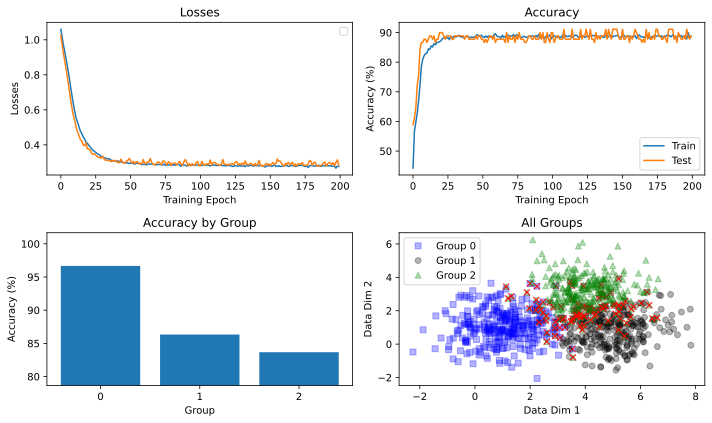

In [11]:
# Test the model without the additional feature
trainAcc, testAcc, losses, net = function2trainTheModel(False)
print("The final Accuracy is: {:.2f}%".format(testAcc[-1].item()))
plotTheResults()

The final Accuracy is: 57.78%


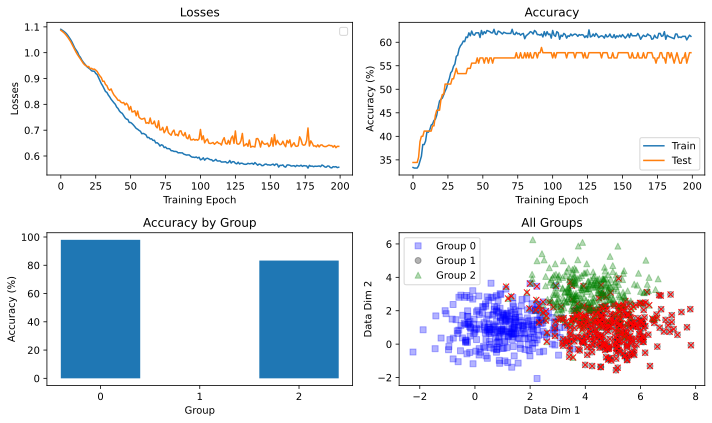

In [12]:
# Test the model with the additional feature
trainAcc, testAcc, losses, net = function2trainTheModel(True)
print("The final Accuracy is: {:.2f}%".format(testAcc[-1]))
plotTheResults()

In [13]:
# From the above results, we do not know whether adding the extra feature increases model accuracy.
# Run the experiment multiple times and do a t-test for significance

finalAcc2 = np.zeros(10)
finalAcc3 = np.zeros(10)

for i in range(10):
    # Obtain only the final element of test accuracy
    finalAcc2[i] = function2trainTheModel(False)[1][-1]
    finalAcc3[i] = function2trainTheModel(True)[1][-1]

# Show the numbers
print(np.round(np.vstack((finalAcc2, finalAcc3)).T,2))

[[62.22 91.11]
 [55.56 86.67]
 [62.22 56.67]
 [86.67 87.78]
 [62.22 86.67]
 [56.67 60.  ]
 [27.78 27.78]
 [58.89 58.89]
 [88.89 62.22]
 [86.67 60.  ]]


In [14]:
# Run a t-test and show the results
from scipy import stats
t,p = stats.ttest_ind(finalAcc2, finalAcc3)
print("\n\nt=%.2f, p=%.2f" %(t,p))
# No statistically significant difference. Augmentation did not help in classification!



t=-0.35, p=0.73


# Getting Data into Colab

## 1 - Image Data

In [15]:
# torchvision library is a must for this task
import torchvision

# Download CIFAR10 dataset
cdata = torchvision.datasets.CIFAR10(root="cifar10", download=True)
print(cdata)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train


## 2 - Download Data from Web

In [16]:
# Use pandas
import pandas as pd

# URL
marriage_url = "https://www.cdc.gov/nchs/data/dvs/state-marriage-rates-90-95-99-19.xlsx"

# IMport into pandas
data = pd.read_excel(marriage_url, header=5)
data.head()

,Unnamed: 0,2019,2018,2017,2016,2015,2014,2013,2012,2011,...,2006,2005,2004,2003,2002,2001,2000,1999,1995,1990
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,6.697687,6.760408,7.047340,7.147821,7.351544,7.806776,7.817785,8.2,8.4,...,9.2,9.2,9.4,9.6,9.9,9.4,10.1,10.8,9.8,10.6
2,Alaska,6.512245,6.683952,6.914078,7.103441,7.407588,7.508836,7.293928,7.2,7.8,...,8.2,8.2,8.5,8.1,8.3,8.1,8.9,8.6,9.0,10.2
3,Arizona,5.302995,5.534434,5.834867,5.930541,5.922469,5.780449,5.401091,5.6,5.7,...,6.5,6.6,6.7,6.5,6.7,7.6,7.5,8.2,8.8,10.0
4,Arkansas,8.377284,8.863156,9.456845,9.860962,10.040279,10.112026,9.751052,10.9,10.4,...,12.4,12.9,13.4,13.4,14.3,14.3,15.4,14.8,14.4,15.3


## 3 - Upload from Hard Drive

In [17]:
# THis is a slow method
from google.colab import files
uploaded = files.upload()

## 4 - Upload from Google Drive

In [18]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Save and Load Trained Models

In [19]:
# Import the MNIST data in colab
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"),delimiter=",")

# Extract labels
labels = data[:,0]
data = data[:,1:]

# Normalize to range [0 1]
dataNorm = data/np.max(data)
dataNorm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
# Conver the data into tensor and DataLoader Objects
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert to PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate to DataLoader
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [21]:
# Create a class for the model
def createTheMNISTNet():

    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Define input layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # Define Output Layer
            self.output = nn.Linear(32,10)
        
        # Forward Pass
        def forward(self,x):
            
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return torch.log_softmax(self.output(x),axis=1)
    
    # Define a fresh model instance
    net = MNISTNet()

    # Define loss fucntion
    lossfun = nn.NLLLoss()

    # Define the optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

    return net, lossfun, optimizer

In [22]:
# Create a function to train the model
def function2trainTheModel():

    # Define the number of epochs
    numepochs = 50 # To make it faster

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # Initialize the losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Iterate over the Epochs
    for epochi in range(numepochs):

        # Initialize batch info storage
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Store batch losses
            batchLoss.append(loss.item())

            # Store batch Accuracy
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
            # End of bath
        
        # Store mean accuracy of batches for one epoch
        trainAcc.append(np.mean(batchAcc))

        # Store mean losses of batches for one epoch
        losses[epochi,0] = np.mean(batchLoss)

        # Test
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        
        # Test losses per epoch
        losses[epochi,1] = lossfun(yHat,y).item()

        # Store test accuracy for each epoch
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
        # End of Epochs
    
    # Return everything
    return trainAcc, testAcc, losses, net

In [23]:
# Run the model
trainAcc, testAcc, losses, net = function2trainTheModel()

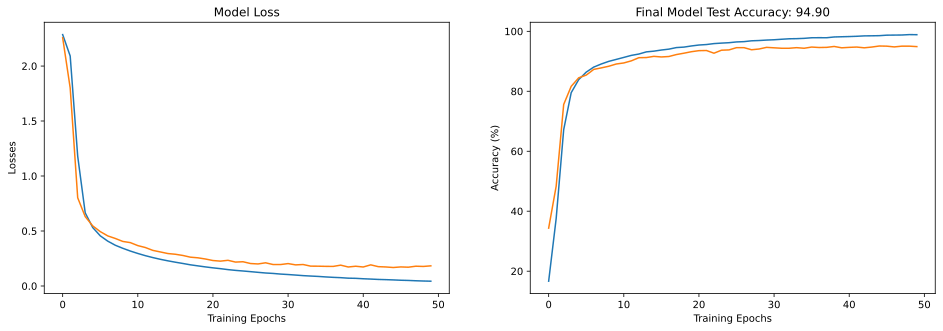

In [24]:
# Visualize the whole thing
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")
ax[0].set_title("Model Loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}".format(testAcc[-1]))
plt.show()

In [25]:
# Save the Model
torch.save(net.state_dict(),"trainedModel.pt")

In [26]:
# Create two new models of the same class (untrained with random initialized weights)
model1 = createTheMNISTNet()[0]
model2 = createTheMNISTNet()[0]

# replace one model's parameters with those of the trained model
# file imported from colab cloud (see folders on the left)
model1.load_state_dict(torch.load("trainedModel.pt"))

<All keys matched successfully>

In [27]:
# Get some data from the test loader
X,y = next(iter(test_loader))

# Run the data through both models
yHatNet = net(X)
yHatModel1 = model1(X)
yHatModel2 = model2(X)

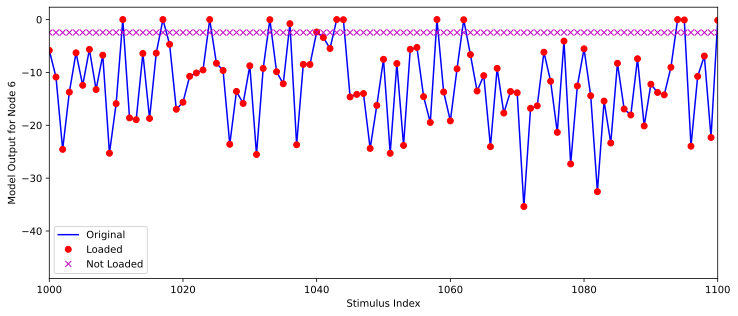

In [28]:
# Show that the results overlap
fig = plt.figure(figsize=(12,5))
plt.plot(yHatNet[:,5].detach(), "b", label="Original")
plt.plot(yHatModel1[:,5].detach(), "ro", label="Loaded")
plt.plot(yHatModel2[:,5].detach(), "mx", label="Not Loaded")
plt.xlabel("Stimulus Index")
plt.ylabel("Model Output for Node 6")
plt.legend()
plt.xlim([1000,1100])
plt.show()

# Save the Best Performing Model

## Brief Aside of Saving the Highest Random Number

In [29]:
theBest = [0,0]

for i in range(10):

    # train the model
    accuracy = np.random.rand()

    # See of this is better than any previous run
    if accuracy > theBest[0]:
        theBest = [accuracy,i]

print(f"The Highest Accuracy was {100*theBest[0]:.2f}% in run {theBest[1]+1}")

The Highest Accuracy was 76.92% in run 3


In [30]:
accuracy

0.10589125384454479

In [31]:
theBest

[0.7691681202096133, 2]

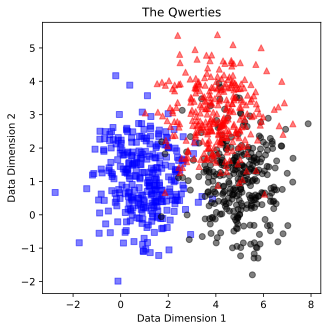

In [32]:
# Create the data
# Number of data points
nPerClust = 300
# define SDV
blur = 1

A = [1,1]
B = [5,1]
C = [4,3]

# Generate the data around these points
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]

data_np = np.hstack((a,b,c)).T

# Define the true labels
labels_np = np.hstack((np.zeros((nPerClust)),
                       np.ones((nPerClust)),
                       np.ones((nPerClust)) +1))

# Convert them into tensors
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

# PLot the whole thing
fig = plt.figure(figsize=(5,5))

plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1],"bs", alpha=0.5)
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1],"ko", alpha=0.5)
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1],"r^", alpha=0.5)

plt.title("The Qwerties")
plt.xlabel("Data Dimension 1")
plt.ylabel("Data Dimension 2")
plt.show()

In [33]:
# Specify sizes of the partitions
# Order is train, devset, test
partitions = [3*nPerClust-400,200,200]
# [500, 200, 200]

# Use sikitlearn to split the data into train and test
train_data, devset_data, train_labels, devset_labels = train_test_split(data, labels, train_size=partitions[0])

# Now split the devset data
dev_data, test_data, dev_labels, test_labels = train_test_split(devset_data, devset_labels, train_size=partitions[1])

# Print out the sizes
print("Total Data Size: {}".format(data.shape))
print("Training Data Size: {}".format(train_data.shape))
print("Devset Data Size: {}".format(dev_data.shape))
print("Test Data Size: {}".format(test_data.shape))

Total Data Size: torch.Size([900, 2])
Training Data Size: torch.Size([500, 2])
Devset Data Size: torch.Size([200, 2])
Test Data Size: torch.Size([200, 2])


In [34]:
# Convert them to PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
dev_data = TensorDataset(dev_data, dev_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into dataloader objects
batchsize = 30
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle = True, drop_last=True)
dev_loader = DataLoader(dev_data, batch_size=dev_data.tensors[0].shape[0])
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [35]:
# Create the Model
def createTheQwertyNet():

    class QwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Define the input layer
            self.input = nn.Linear(2,8)
            
            # Hidden Layer
            self.fc1 = nn.Linear(8,8)

            # Output Layer
            self.output = nn.Linear(8,3)

        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return F.relu(self.output(x))
    
    # Create the model instance
    net = QwertyNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimization function
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

    return net, lossfun, optimizer

In [36]:
import copy
# Define a function to train the model
def function2trainTheModel():

    # Initialize a dictionary for the best model
    theBestModel = {"Accuracy":0, "net":None}

    # Define the number of epochs
    numepochs = 250

    # Create a new model
    net, lossfun, optimizer = createTheQwertyNet()

    # INitialize the losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    devAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Initialize the batches information
        batchAcc = []
        batchLoss = []

        # Loop over the batches
        for X,y in train_loader:

            # Forward Pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackPropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Store the losses for this particular batch
            batchLoss.append(loss.item())

            # Store batch Accuracy
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
        # End of batch
        # Save the mean accuracy and loss for the batches in one epoch
        trainAcc.append(np.mean(batchAcc))
        losses[epochi,0] = np.mean(batchLoss)

        # Test the Accuracy for each epoch on devset
        net.eval()
        X,y = next(iter(dev_loader))
        with torch.no_grad():
            yHat = net(X)
        # Test Losses per epoch
        losses[epochi,1] = lossfun(yHat,y).item()

        # Test Accuracy per epich
        devAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

        # Store the model if it is the best so far
        if devAcc[-1] > theBestModel["Accuracy"]:

            # New best accuracy
            theBestModel["Accuracy"] = devAcc[-1].item()

            # Model's internal state
            theBestModel["net"] = copy.deepcopy(net.state_dict())
        # End of Epochs

    # Return the calculations
    return trainAcc, devAcc, losses, theBestModel

In [37]:
# Run the Model
trainAcc, devAcc, losses, theBestModel = function2trainTheModel()

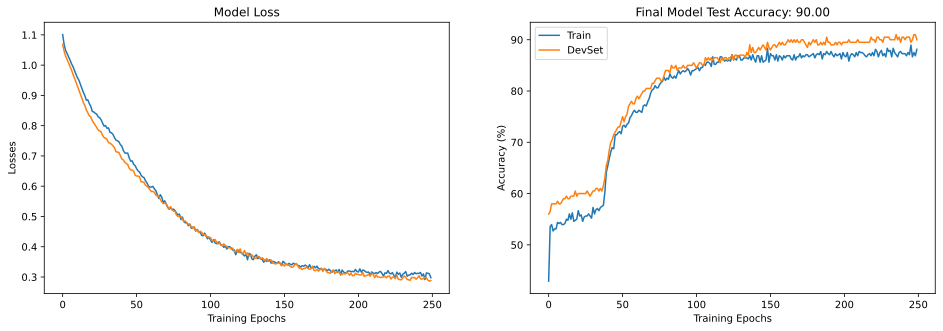

In [38]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")
ax[0].set_title("Model Loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(devAcc, label="DevSet")
ax[1].legend()
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}".format(devAcc[-1]))
plt.show()

In [39]:
theBestModel

{'Accuracy': 91.0,
 'net': OrderedDict([('input.weight', tensor([[ 0.9448,  0.2193],
                       [ 0.4735,  0.9747],
                       [-0.1379,  0.7966],
                       [-0.1722,  0.7988],
                       [ 0.5260,  0.3720],
                       [-0.6082,  0.2749],
                       [ 0.3797,  0.0287],
                       [-0.4375, -0.1555]])),
              ('input.bias',
               tensor([-0.5200,  0.0139,  0.5620,  0.8968, -0.7194, -0.0603,  0.7385, -0.0124])),
              ('fc1.weight',
               tensor([[-0.2378,  0.2003, -0.2148,  0.0091, -0.1812, -0.2255, -0.1954, -0.1598],
                       [-0.4132,  0.3847,  0.3012,  0.9311, -0.2776,  0.2219,  0.5453, -0.0264],
                       [ 0.0857,  0.2219, -0.3030, -0.0075, -0.3065, -0.2020, -0.2083,  0.1390],
                       [ 0.5970,  0.7947,  0.1794,  0.0452,  0.7213, -0.3125, -0.2574,  0.3424],
                       [ 0.0189,  0.1789,  0.0060,  0.0360, -0.2505

In [40]:
# Extract X,y from test_dataloader
X,y = next(iter(test_loader))
# yHat = theBestModel["net"](X) (doesnt work)

In [41]:
# Recreate the highest performing model
# First create a fresh model instance
bestnet = createTheQwertyNet()[0]

# Then copy the best model's parameters in it
bestnet.load_state_dict(theBestModel["net"])

<All keys matched successfully>

In [42]:
# Run the Data Through Test
X,y = next(iter(test_loader))
yHat = bestnet(X)

bestAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
bestAcc

tensor(87.5000)

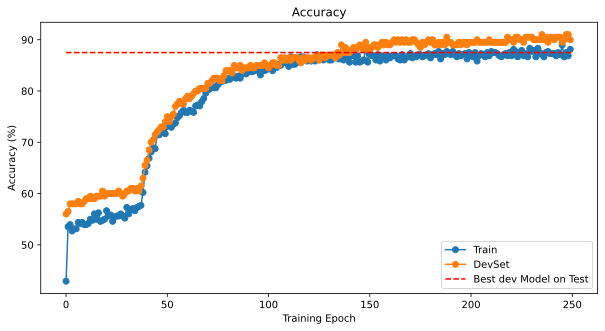

In [43]:
# Plot
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc, "o-", label="Train")
plt.plot(devAcc, "o-", label="DevSet")
plt.plot([0,len(devAcc)], [bestAcc, bestAcc], "r--", label="Best dev Model on Test")
plt.ylabel("Accuracy (%)")
plt.xlabel("Training Epoch")
plt.title("Accuracy")
plt.legend()
plt.show()